In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/seattle_sample_3k.csv')

In [3]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
data = data.to_crs(4326)

In [5]:
data['lon'] = data['geometry'].get_coordinates()['x']

In [6]:
data['lat'] = data['geometry'].get_coordinates()['y']

In [7]:
data['price'] = np.power(10, data['log_price']) / 10000

In [8]:
y = data.price
X = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'lon', 'lat']]
loc = data[['lon', 'lat']]

In [9]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X, y, loc, train_size=0.8, random_state=42)

In [10]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [11]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)

In [12]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
feature_names = X_train.columns

In [14]:
explainer = explainer = GeoConformalizedExplainer(prediction_f=model.predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      coord_test=loc_test.values,
                                      miscoverage_level=0.1,
                                      band_width=0.15,
                                      feature_names=feature_names)

In [15]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

Training SHAP


100%|██████████| 2400/2400 [15:14<00:00,  2.63it/s]


Calibrating SHAP


100%|██████████| 300/300 [01:47<00:00,  2.79it/s]


Testing SHAP


100%|██████████| 300/300 [03:03<00:00,  1.64it/s]


Explaining Variables


In [16]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
bathrooms,0.906667,0.505355,1.489173,4.483291,2.753743
sqft_living,0.890000,0.906089,2.919406,90.755139,109.973182
sqft_lot,0.903333,0.830772,1.869189,20.645870,20.157265
grade,0.960000,0.969499,1.813923,107.876885,124.939926
condition,0.896667,0.812063,0.717027,2.735647,3.147237
waterfront,0.473333,0.777434,2.335054,24.498211,7.705255
view,0.840000,0.867039,1.981644,29.534360,15.930655
age,0.846667,0.487233,2.280874,10.145709,10.401115
lon,0.876667,0.604595,2.642612,17.661366,14.261512
lat,0.963333,0.955065,3.308054,243.532290,275.306476


In [17]:
results.accuracy_summary().to_csv('./SeattleHomeSale_accuracy_summary.csv')

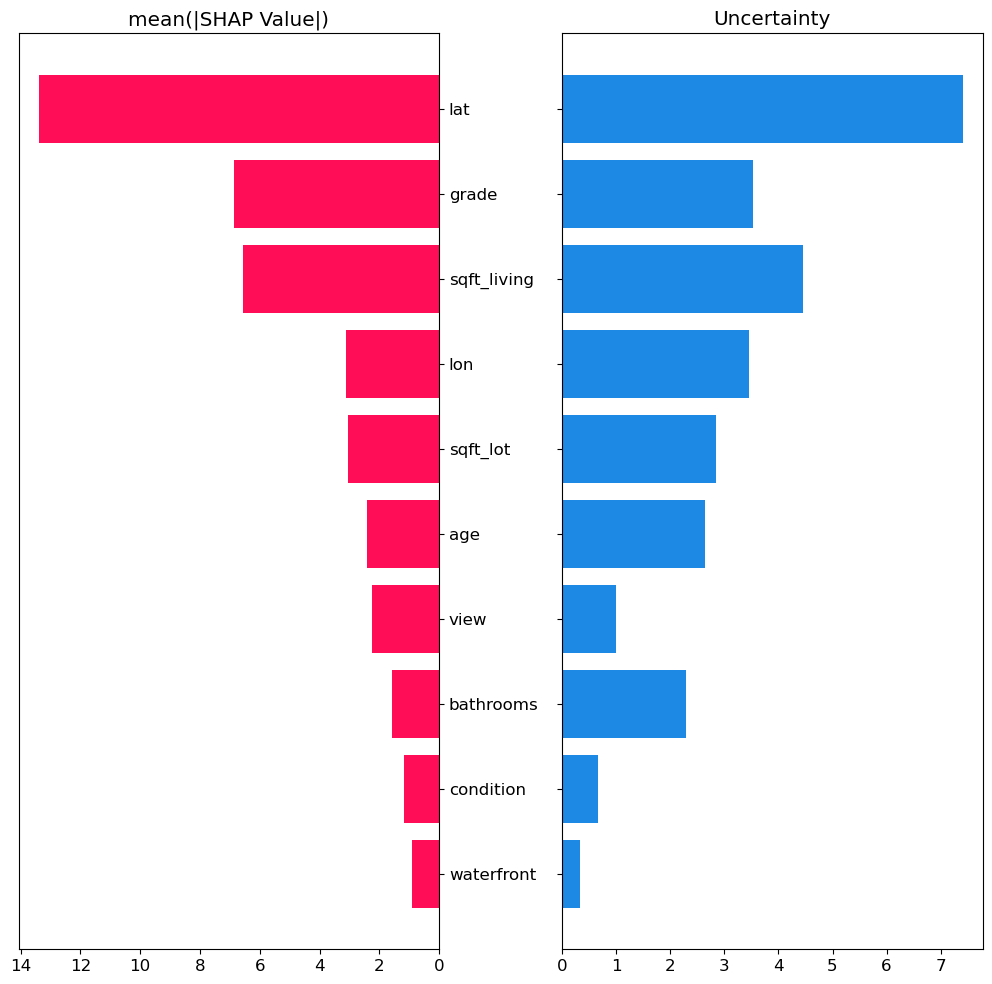

In [18]:
results.plot_absolute_shap_value_with_uncertainty(filename='./SeattleHomeSale_absolute_shap_value_with_uncertainty.pdf')

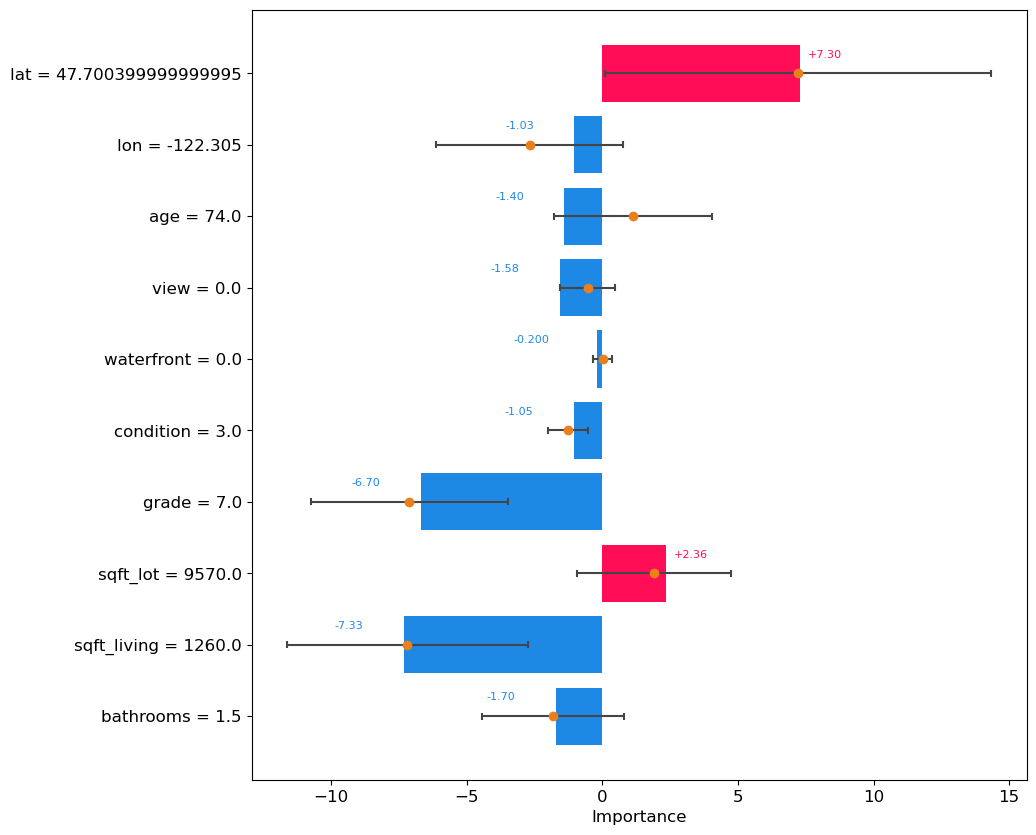

In [19]:
results.plot_shap_values_with_uncertainty(20, filename='./SeattleHomeSale_shap_values_with_uncertainty.pdf')

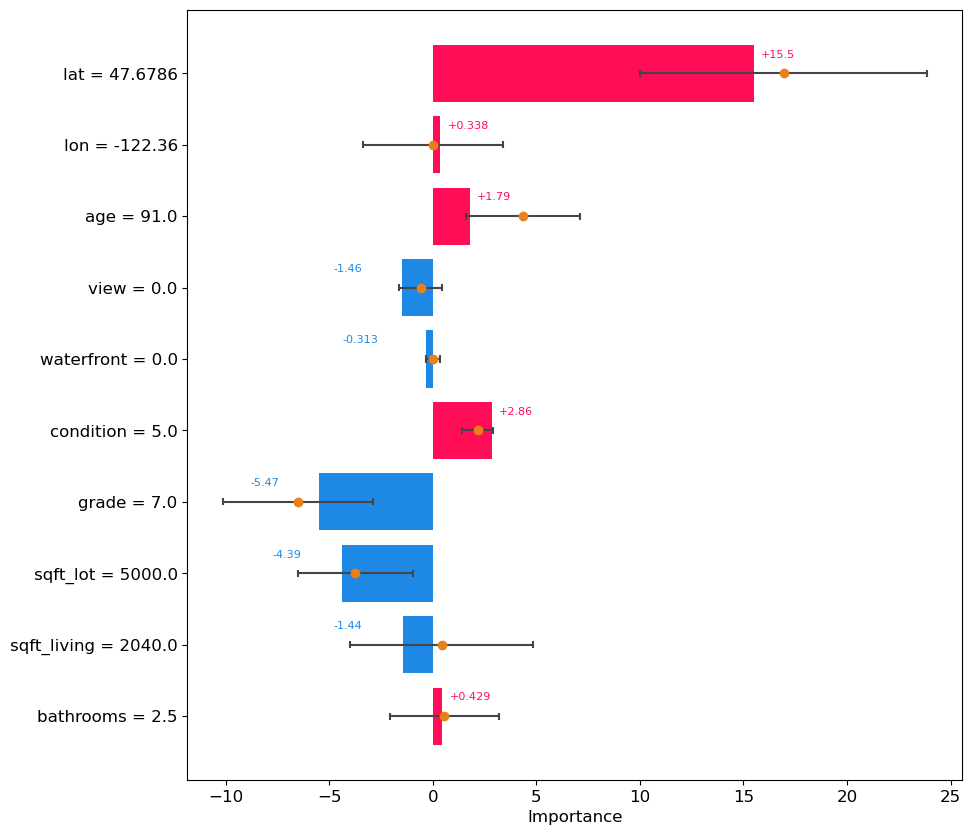

In [20]:
results.plot_shap_values_with_uncertainty(40)

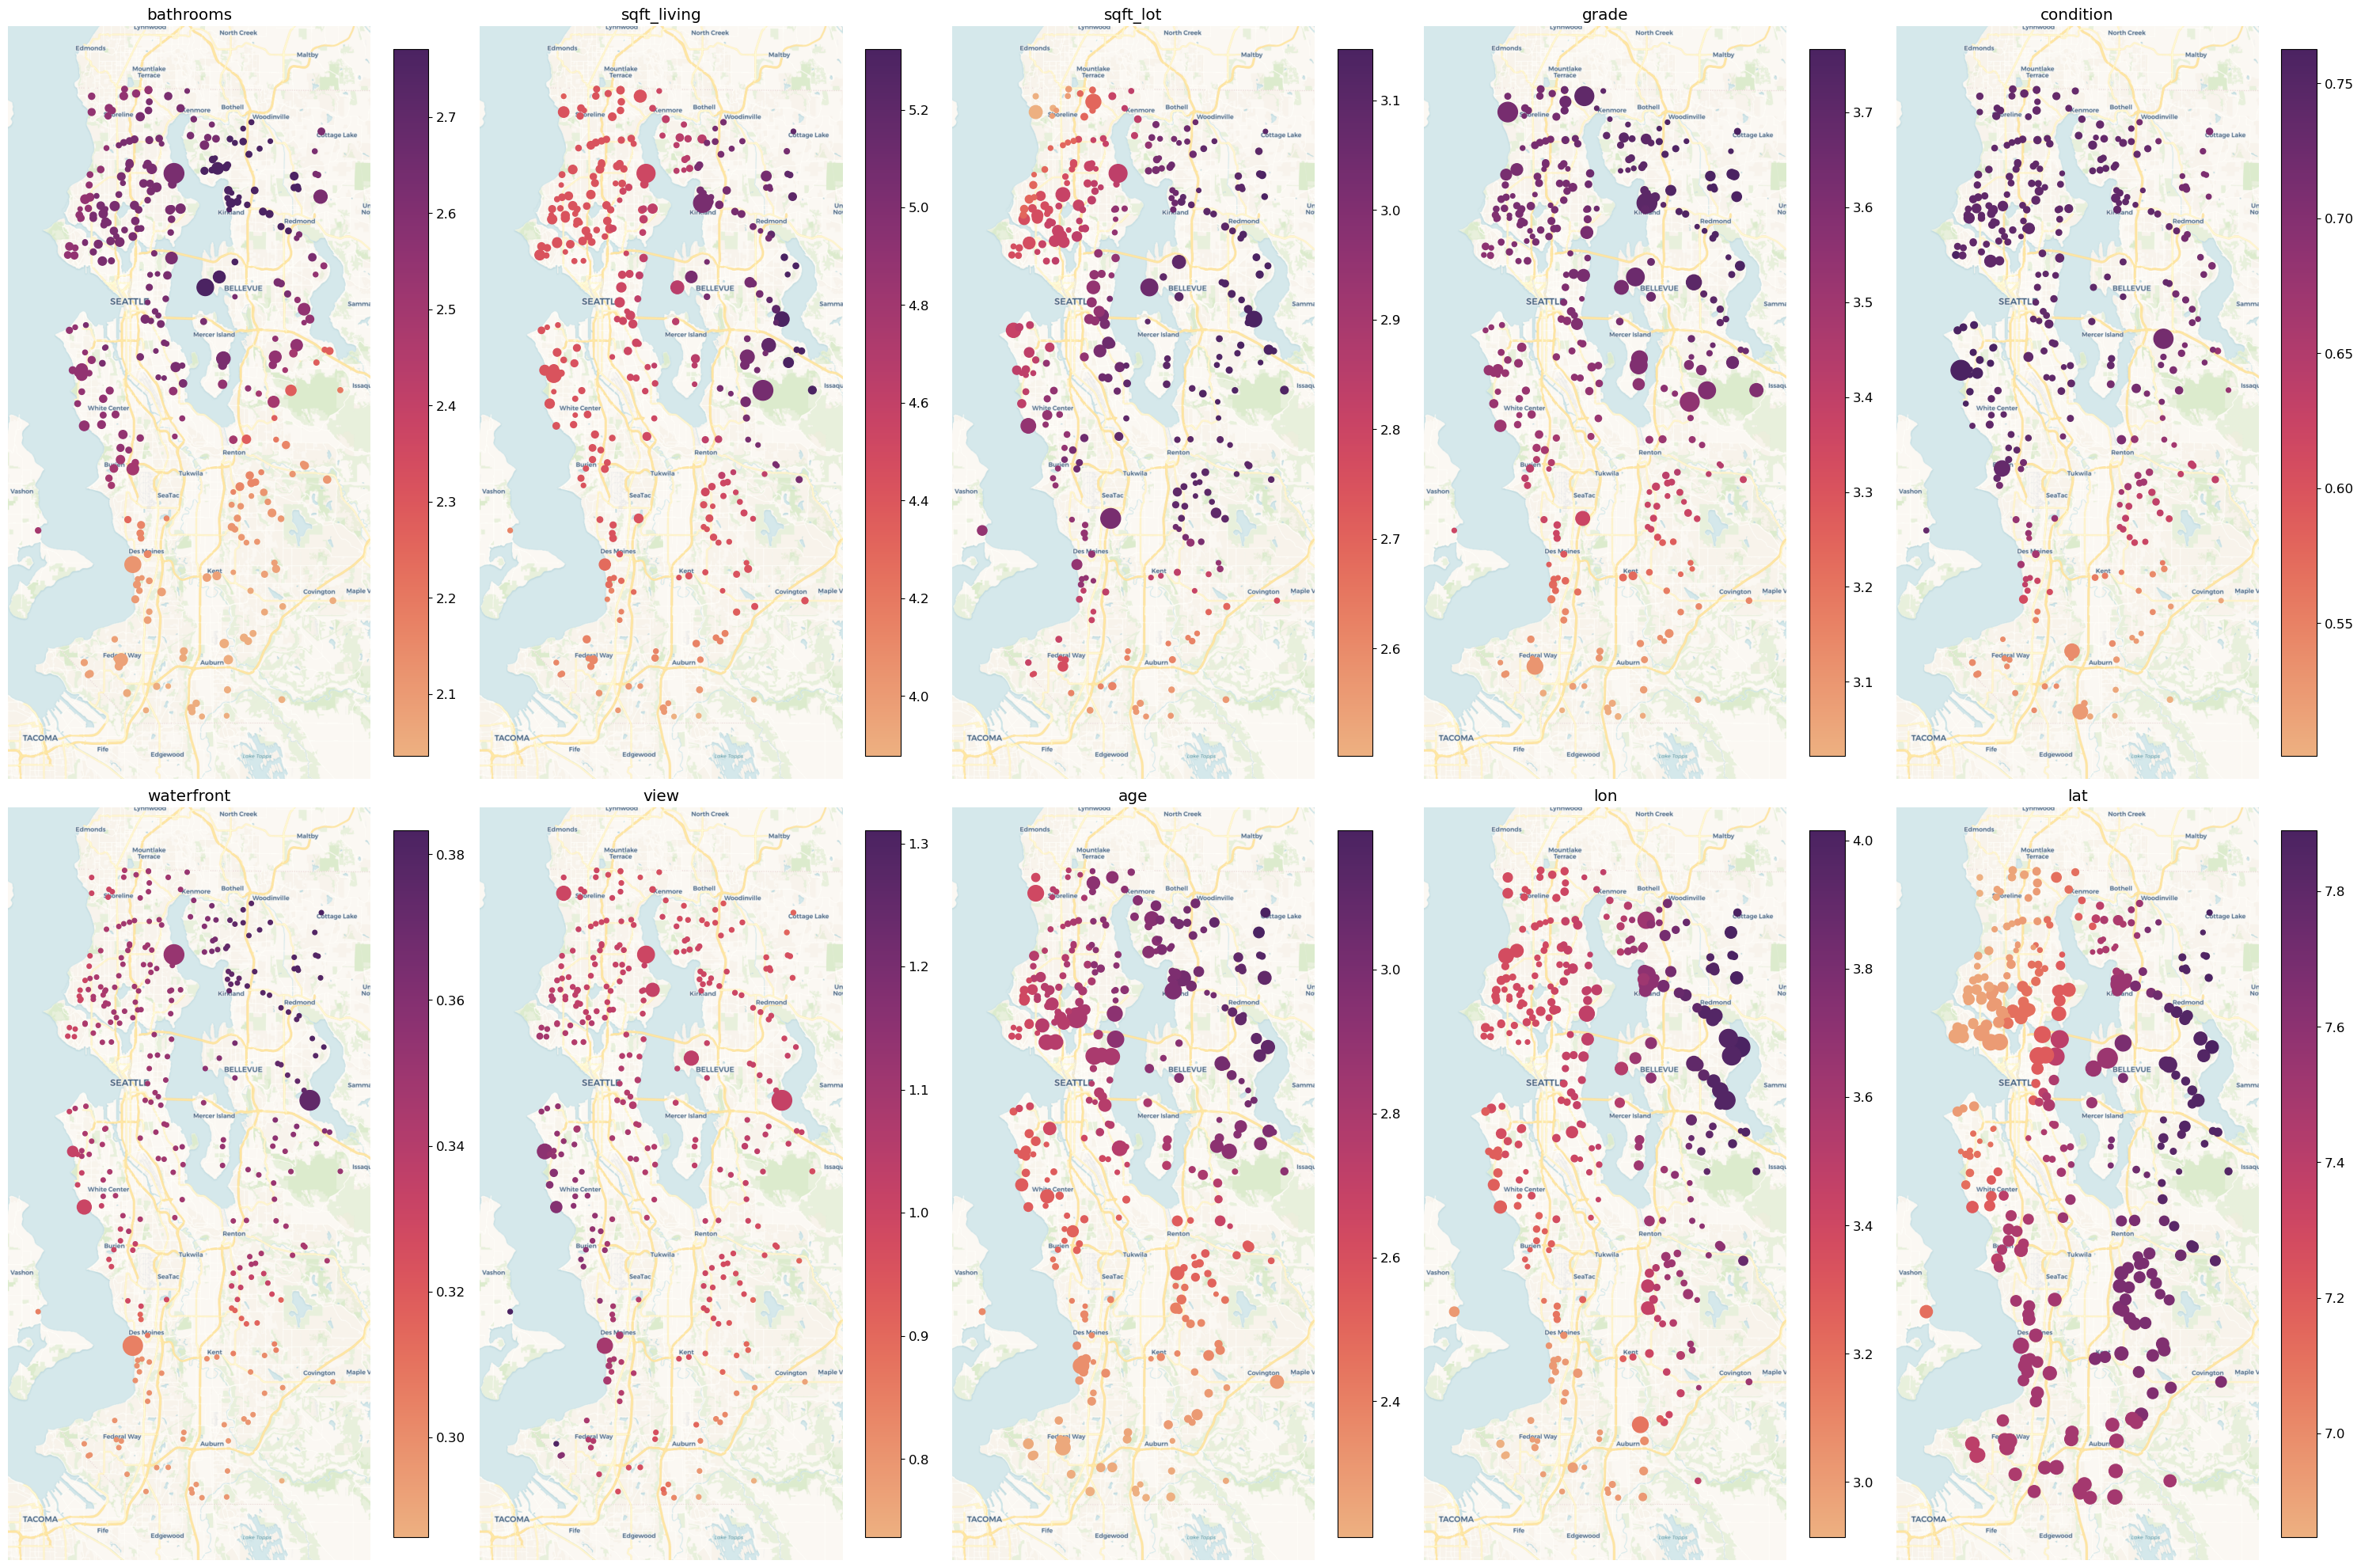

In [24]:
results.plot_geo_uncertainty(figsize=[30, 40], shrink=0.3, s_limits=(4, 18), cmap='flare', filename='./SeattleHomeSale_geo_uncertainty.pdf')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

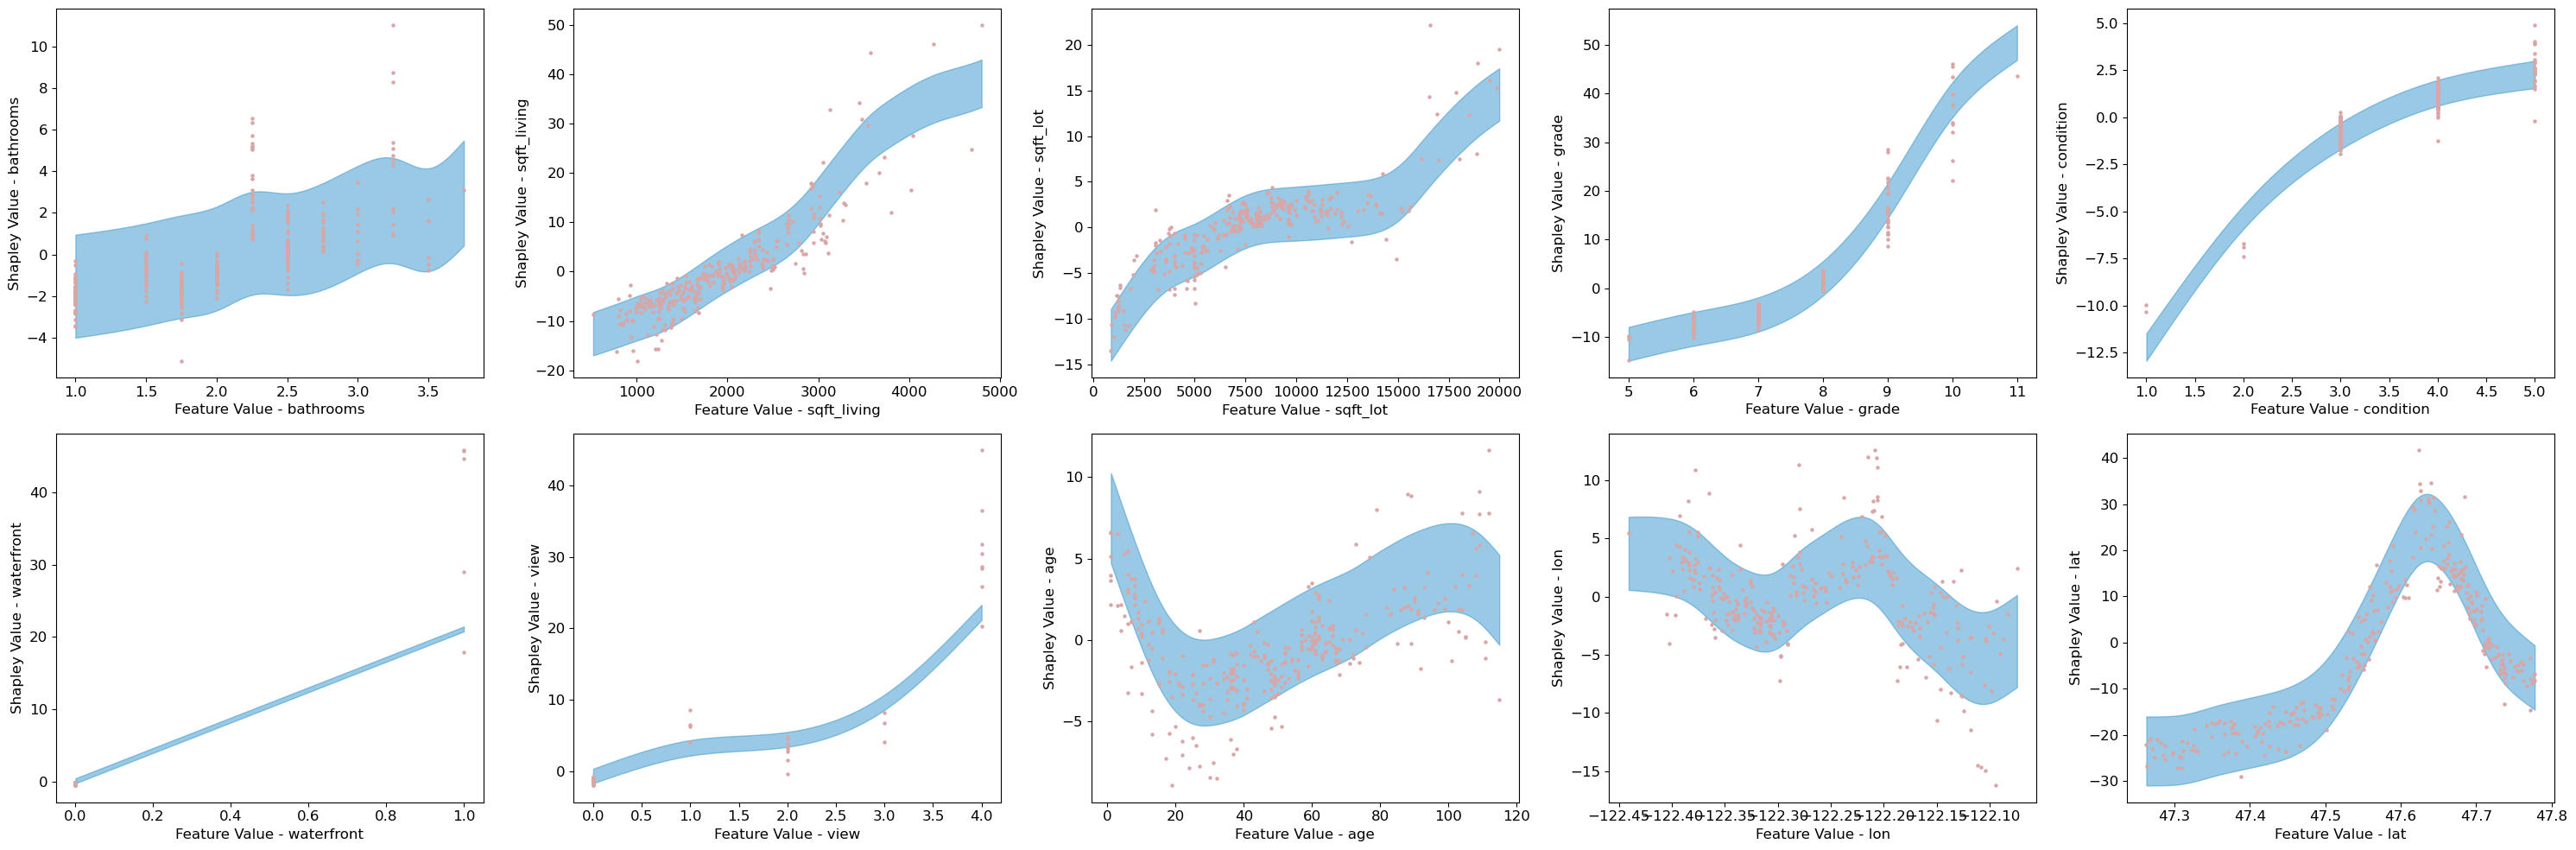

In [22]:
results.plot_partial_dependence_with_fitted_bounds(figsize=[30, 10], filename='SeattleHomeSale_partial_dependence_with_fitted_bounds.pdf')